In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!conda install -y gdown
!gdown --id 1rxIHMPYPL4qnfjujvhiNGH2PnezOBKQa

/bin/bash: line 1: conda: command not found
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rxIHMPYPL4qnfjujvhiNGH2PnezOBKQa
To: /content/q1_model2.pth
100% 525M/525M [00:02<00:00, 235MB/s]


In [4]:
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.5MB/s]


In [5]:
# Data processing pipeline
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=t)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=t)

# Data loaders
train_loader = DataLoader(torch.utils.data.Subset(train_set, [i for i, label in enumerate(train_set.targets) if label in [0, 1]]), batch_size=64, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(test_set, [i for i, label in enumerate(test_set.targets) if label in [0, 1]]), batch_size=64, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:13<00:00, 13084424.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  3%|▎         | 4/157 [00:02<01:38,  1.55it/s]


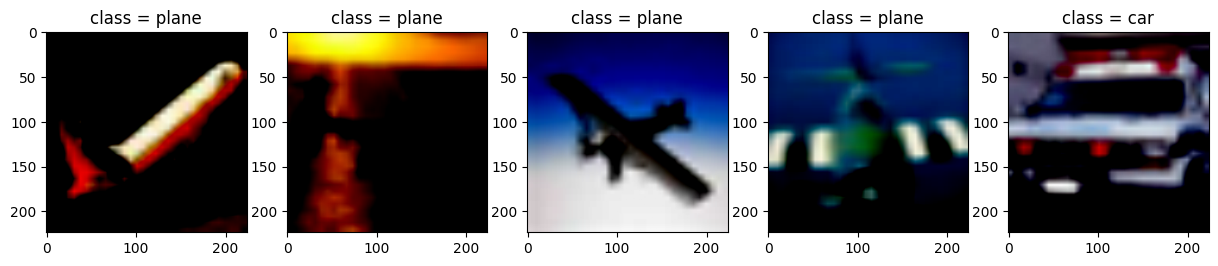

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Iterate through the first 5 elements of the data loader
for i, (x, y) in enumerate(tqdm(train_loader)):
    idx = 0
    plt.subplot(1, 5, i + 1)  # Adjust subplot to display images side by side
    plt.imshow(x[idx].numpy().transpose(1, 2, 0))
    plt.title(f'class = {classes[y[idx]]}')

    if i == 4:  # Break after plotting 5 images
        break

# Show the plot
plt.show()

In [ ]:
print(resnet50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
import torch.nn as nn

# Lock all parameters
for p in resnet50.parameters():
    p.requires_grad = False

my_classifier = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=1000, out_features=10, bias=True),  # Change out_features to the desired number of classes
)

resnet50.fc = my_classifier
resnet50 = resnet50.cuda()

In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop
from tqdm import tqdm

# Define the CrossEntropyLoss criterion
classification_criterion = CrossEntropyLoss()

# Define the RMSprop optimizer for the ResNet50 model
resnet50_optimizer = RMSprop(resnet50.parameters(), lr=0.01, alpha=0.9)

# Lists to store training losses and accuracies
training_losses = []
training_accuracies = []

# Training loop
for epoch in range(15):
    total_epoch_loss = 0
    total_train_accuracy = 0

    # Iterate through the training data loader
    for (data, targets) in tqdm(train_loader):
        # Zero out the gradients
        resnet50_optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(data.cuda())

        # Calculate the loss
        loss = classification_criterion(outputs, targets.cuda())

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs, 1)
        train_accuracy = (predicted_train == targets.cuda()).sum().item() / len(targets.cuda())
        total_train_accuracy += train_accuracy

        # Backward pass and optimization
        total_epoch_loss += loss.item()
        loss.backward()
        resnet50_optimizer.step()

    # Calculate average epoch loss and accuracy
    average_epoch_loss = total_epoch_loss / len(train_loader)
    average_train_accuracy = (total_train_accuracy / len(train_loader)) * 100

    # Print and store results
    print(f'Loss at epoch {epoch}: {average_epoch_loss}')
    print(f'Train accuracy at epoch {epoch}: {average_train_accuracy}%')

    training_losses.append(average_epoch_loss)
    training_accuracies.append(average_train_accuracy)




100%|██████████| 157/157 [01:37<00:00,  1.60it/s]


Loss at epoch 0: 6.175784732078671
Train accuracy at epoch 0: 76.43312101910828%


100%|██████████| 157/157 [01:33<00:00,  1.67it/s]


Loss at epoch 1: 0.479275717666954
Train accuracy at epoch 1: 87.390525477707%


100%|██████████| 157/157 [01:32<00:00,  1.69it/s]


Loss at epoch 2: 0.3785134375949574
Train accuracy at epoch 2: 89.91839171974523%


100%|██████████| 157/157 [01:30<00:00,  1.73it/s]


Loss at epoch 3: 0.3770212726845483
Train accuracy at epoch 3: 90.71457006369427%


100%|██████████| 157/157 [01:31<00:00,  1.71it/s]


Loss at epoch 4: 0.2527126708441669
Train accuracy at epoch 4: 92.36664012738854%


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


Loss at epoch 5: 0.2689954377948099
Train accuracy at epoch 5: 92.06807324840764%


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Loss at epoch 6: 0.26678055064503553
Train accuracy at epoch 6: 92.83439490445859%


100%|██████████| 157/157 [01:22<00:00,  1.90it/s]


Loss at epoch 7: 0.2611561787320645
Train accuracy at epoch 7: 92.46616242038218%


100%|██████████| 157/157 [01:30<00:00,  1.74it/s]


Loss at epoch 8: 0.24820948536893364
Train accuracy at epoch 8: 92.69506369426752%


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


Loss at epoch 9: 0.2288262237361662
Train accuracy at epoch 9: 93.27229299363057%


100%|██████████| 157/157 [01:23<00:00,  1.88it/s]


Loss at epoch 10: 0.22842288466324662
Train accuracy at epoch 10: 93.47133757961782%


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


Loss at epoch 11: 0.21678118783221312
Train accuracy at epoch 11: 93.54100318471338%


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Loss at epoch 12: 0.25059087096363497
Train accuracy at epoch 12: 93.33200636942675%


100%|██████████| 157/157 [01:34<00:00,  1.65it/s]


Loss at epoch 13: 0.22563553437780423
Train accuracy at epoch 13: 93.67038216560509%


100%|██████████| 157/157 [01:29<00:00,  1.75it/s]

Loss at epoch 14: 0.19255092600063914
Train accuracy at epoch 14: 94.15804140127389%


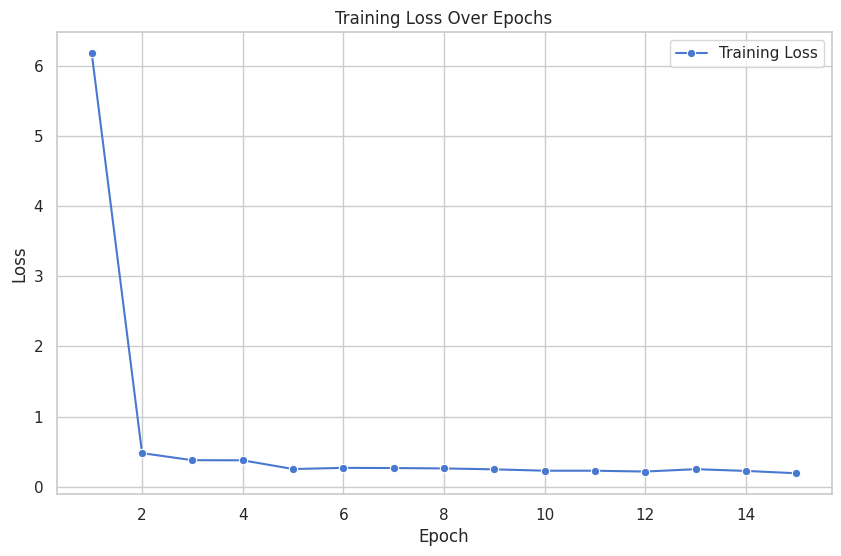

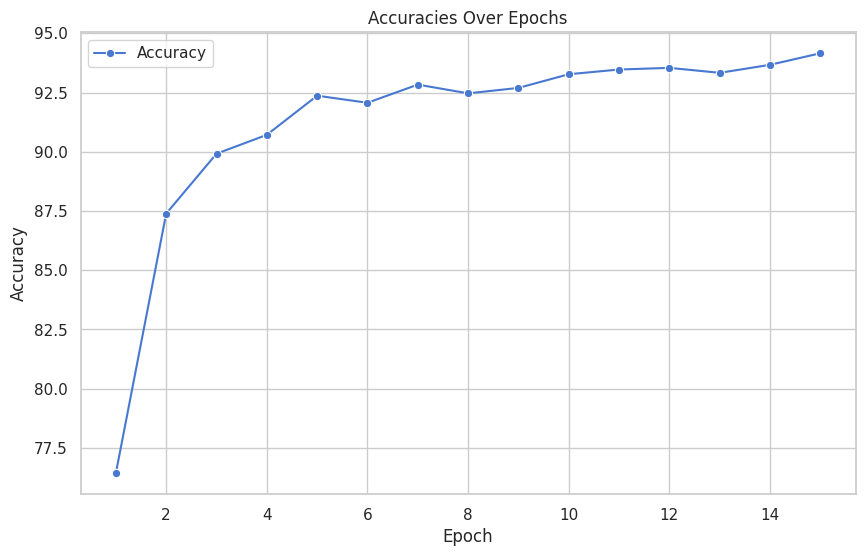

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(training_losses) + 1), y=training_losses, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(training_accuracies) + 1), y=training_accuracies, marker='o', label='Accuracy')
plt.title('Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:

# Assuming 'resnet50' is your pre-trained model
resnet50.eval()

with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for data, targets in train_loader:

        # Forward pass
        train_outputs = resnet50(data.cuda())

        # Get predictions
        _, predicted_train = torch.max(train_outputs, 1)

        # Calculate accuracy
        total_correct += (predicted_train == targets.cuda()).sum().item()
        total_samples += targets.cuda().size(0)

# Calculate accuracy percentage
train_accuracy = (total_correct / total_samples) * 100

print('\nTrain Accuracy: {:.2f}%'.format(train_accuracy))

import torch

# Assuming 'resnet50' is your pre-trained model
resnet50.eval()

with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for data, targets in test_loader:
        data = data.cuda()
        targets = targets.cuda()

        # Forward pass
        test_outputs = resnet50(data)

        # Get predictions
        _, predicted_test = torch.max(test_outputs, 1)

        # Calculate accuracy
        total_correct += (predicted_test == targets).sum().item()
        total_samples += targets.size(0)

# Calculate accuracy percentage
test_accuracy = (total_correct / total_samples) * 100

print('\nTest Accuracy: {:.2f}%'.format(test_accuracy))



Train Accuracy: 96.20%

Test Accuracy: 95.15%


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.modules import ReLU,Linear,Dropout
from torchvision.datasets import CIFAR10

import numpy as np
class TripletDataset(Dataset):
    def __init__(self, root_dir, train, transform=None, selected_classes=[0,1]):
        self.root_dir = root_dir
        self.transform = transform

        self.cifar10_dataset = datasets.CIFAR10(
            root=self.root_dir,
            train=train,
            download=True,
            transform=transform)

        # select 'airplane' and 'automobile' class
        self.reduced_indices = [i for i in range(len(self.cifar10_dataset.targets)) if self.cifar10_dataset.targets[i] in selected_classes]
        self.reduced_dataset = Subset(self.cifar10_dataset, self.reduced_indices)

    def __getitem__(self, index):
        anchor, anchor_label = self.reduced_dataset[index]

        anch_label = torch.tensor(self.cifar10_dataset.targets)[self.reduced_indices]
        # get positive and negative samples
        positive, _ = self.reduced_dataset[np.random.choice(torch.nonzero(anch_label == anchor_label).squeeze().numpy())]
        negative, _ = self.reduced_dataset[np.random.choice(torch.nonzero(anch_label != anchor_label).squeeze().numpy())]

        return anchor, positive, negative, anchor_label

    def __len__(self):
        return len(self.reduced_dataset)

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet50_FE = models.resnet50(weights='DEFAULT')
        resnet50_FE.fc = nn.Identity()
        self.FE = resnet50_FE

    def forward(self, x):
        return self.FE(x)


trip_train_dataset = TripletDataset(root_dir='./data',train=True,
                                           transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

trip_test_dataset = TripletDataset(root_dir='./data',train=False,
                                          transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

# create DataLoader

batch_size = 64
triplet_train_loader = DataLoader(trip_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = DataLoader(trip_test_dataset, batch_size=batch_size, shuffle=False)


FeatureExtractor = FeatureExtractor().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
triplet_loss = nn.TripletMarginLoss()
optimizer    = torch.optim.Adam(FeatureExtractor.parameters(), lr=0.001)

triple_losses = []
num_epochs = 15
# Train the model

for epoch in range(num_epochs):
    FeatureExtractor.train()
    epoch_loss = 0.0

    for anchor, positive, negative, _ in tqdm(triplet_train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()

        loss = triplet_loss(FeatureExtractor(anchor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))),
                            FeatureExtractor(positive.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))),
                            FeatureExtractor(negative.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(triplet_train_loader)


    epoch_info = 'Epoch: {}, \tLoss: {:.5f}'.format(epoch, epoch_loss)
    print(epoch_info)

    triple_losses.append(epoch_loss)

Epoch 1/15: 100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


Epoch: 0, 	Loss: 1.25155


Epoch 2/15: 100%|██████████| 157/157 [02:33<00:00,  1.03it/s]


Epoch: 1, 	Loss: 0.25180


Epoch 3/15: 100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


Epoch: 2, 	Loss: 0.12285


Epoch 4/15: 100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


Epoch: 3, 	Loss: 0.07349


Epoch 5/15: 100%|██████████| 157/157 [02:22<00:00,  1.10it/s]


Epoch: 4, 	Loss: 0.03592


Epoch 6/15: 100%|██████████| 157/157 [02:23<00:00,  1.09it/s]


Epoch: 5, 	Loss: 0.01961


Epoch 7/15: 100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


Epoch: 6, 	Loss: 0.01379


Epoch 8/15: 100%|██████████| 157/157 [02:18<00:00,  1.13it/s]


Epoch: 7, 	Loss: 0.01502


Epoch 9/15: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


Epoch: 8, 	Loss: 0.01177


Epoch 10/15: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s]


Epoch: 9, 	Loss: 0.01163


Epoch 11/15: 100%|██████████| 157/157 [02:14<00:00,  1.17it/s]


Epoch: 10, 	Loss: 0.00610


Epoch 12/15: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s]


Epoch: 11, 	Loss: 0.01215


Epoch 13/15: 100%|██████████| 157/157 [02:13<00:00,  1.18it/s]


Epoch: 12, 	Loss: 0.05704


Epoch 14/15: 100%|██████████| 157/157 [02:20<00:00,  1.11it/s]


Epoch: 13, 	Loss: 0.01968


Epoch 15/15: 100%|██████████| 157/157 [02:15<00:00,  1.16it/s]

Epoch: 14, 	Loss: 0.02105


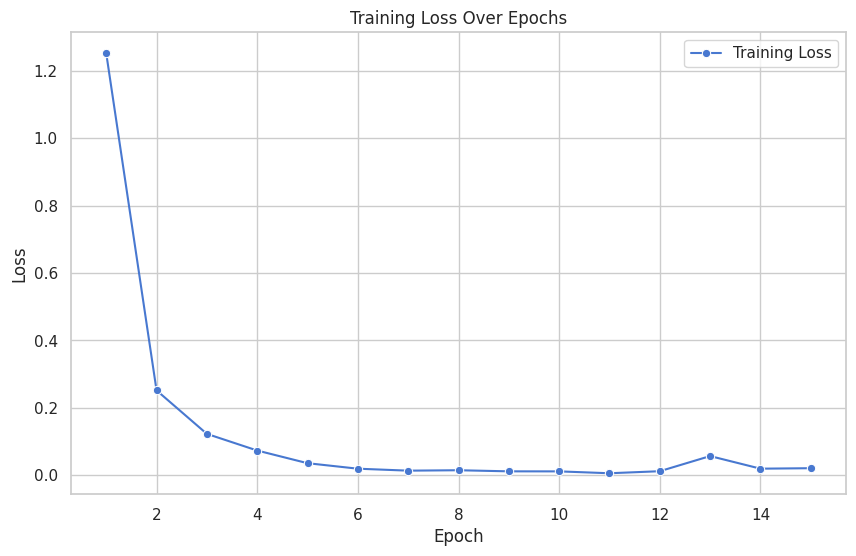

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(triple_losses) + 1), y=triple_losses, marker='o', label='Training Loss')
plt.title('Training Triplet Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
class TripleLossCl(nn.Module):
    def __init__(self,featureExtractor):
        super(TripleLossCl, self).__init__()
        featureExtractor.requires_grad_(True)

        featureExtractor.fc = torch.nn.Sequential(
            nn.Linear(in_features=2048, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6, inplace=False),
            nn.Linear(in_features=1000, out_features=10, bias=True),  # Change out_features to the desired number of classes
        )
        self.feature_extractor = featureExtractor


    def forward(self, x):
        x = self.feature_extractor(x)
        return x


tripleLossCl = TripleLossCl(FeatureExtractor).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = torch.optim.RMSprop(tripleLossCl.parameters(), lr=0.001, alpha=0.09)
criterion = torch.nn.CrossEntropyLoss()

loss_triple_list = []
accuracy_triple_list = []


for epoch in range(15):
    tripleLossCl.train()

    epoch_loss = 0.0
    accuracies = []

    for data, targets in tqdm(train_loader, desc=f'epoch {epoch+1}/{15}'):
        data = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        optimizer.zero_grad()
        outputs = tripleLossCl(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()

        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_loader)

    print(f'Epoch Loss: {epoch_loss:.4f} | Accuracy: {np.mean(accuracies)*100:.2f}%')
    loss_triple_list.append(epoch_loss)
    accuracy_triple_list.append(100*np.mean(accuracies))




epoch 1/15: 100%|██████████| 157/157 [02:00<00:00,  1.31it/s]


Epoch Loss: 0.0414 | Accuracy: 99.43%


epoch 2/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0304 | Accuracy: 99.52%


epoch 3/15: 100%|██████████| 157/157 [01:58<00:00,  1.32it/s]


Epoch Loss: 0.0359 | Accuracy: 99.43%


epoch 4/15: 100%|██████████| 157/157 [01:56<00:00,  1.34it/s]


Epoch Loss: 0.0351 | Accuracy: 99.59%


epoch 5/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0218 | Accuracy: 99.68%


epoch 6/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0156 | Accuracy: 99.74%


epoch 7/15: 100%|██████████| 157/157 [01:58<00:00,  1.32it/s]


Epoch Loss: 0.0131 | Accuracy: 99.84%


epoch 8/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0292 | Accuracy: 99.74%


epoch 9/15: 100%|██████████| 157/157 [01:56<00:00,  1.34it/s]


Epoch Loss: 0.0141 | Accuracy: 99.79%


epoch 10/15: 100%|██████████| 157/157 [01:56<00:00,  1.34it/s]


Epoch Loss: 0.0053 | Accuracy: 99.93%


epoch 11/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0060 | Accuracy: 99.93%


epoch 12/15: 100%|██████████| 157/157 [01:56<00:00,  1.34it/s]


Epoch Loss: 0.0022 | Accuracy: 99.97%


epoch 13/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0011 | Accuracy: 99.98%


epoch 14/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]


Epoch Loss: 0.0000 | Accuracy: 100.00%


epoch 15/15: 100%|██████████| 157/157 [01:57<00:00,  1.34it/s]

Epoch Loss: 0.0000 | Accuracy: 100.00%


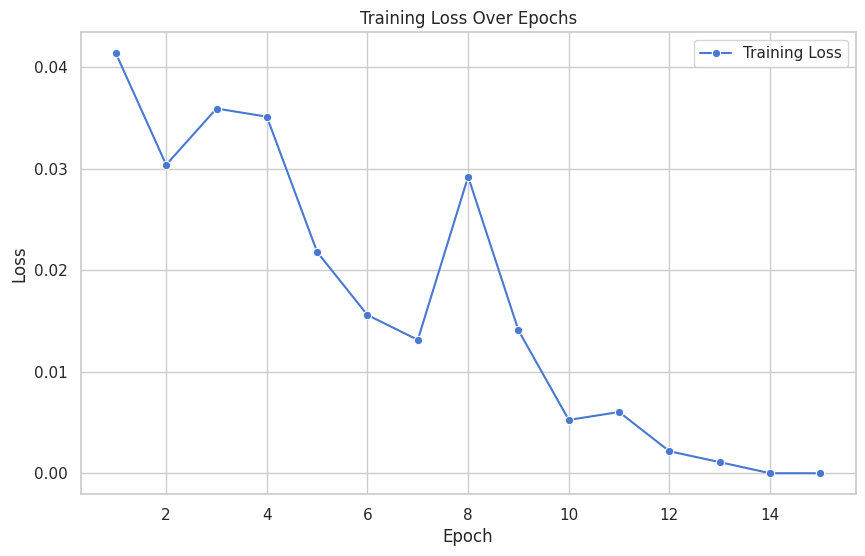

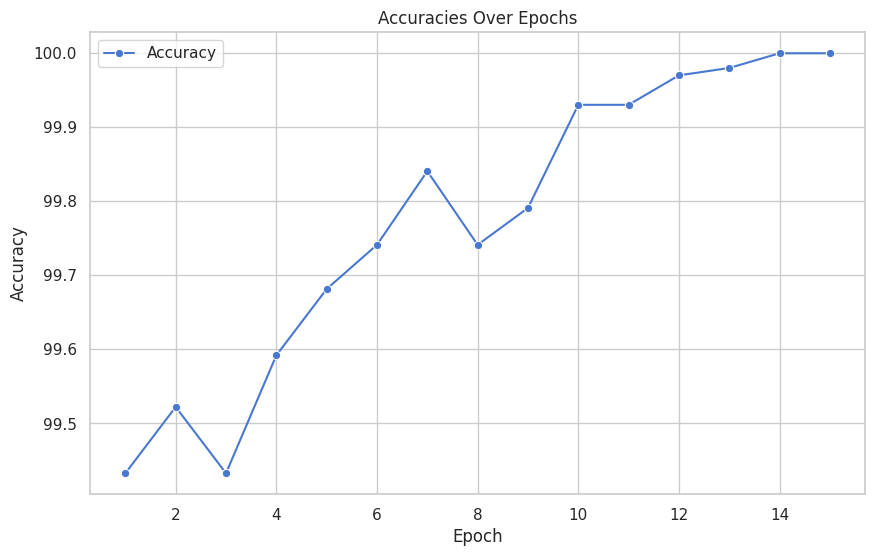

In [ ]:

sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(loss_triple_list) + 1), y=loss_triple_list, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(accuracy_triple_list) + 1), y=accuracy_triple_list, marker='o', label='Accuracy')
plt.title('Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
tripleLossCl.eval()
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_loader):
        test_outputs = tripleLossCl(data.cuda())
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == targets.cuda()).sum().item() / len(targets.cuda())

print(f'test accuracy for 2nd part is : {(test_accuracy/len(test_loader))*100:.5f}%')

100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

test accuracy for 2nd part is : 98.77930%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.modules import ReLU,Linear,Dropout
from torchvision.datasets import CIFAR10
class TotalLossCL(nn.Module):
    def __init__(self):
        super(TotalLossCL, self).__init__()

        self.feature_extractor = models.resnet50(weights='DEFAULT')
        self.feature_extractor.fc = nn.Identity()
        self.classifier = torch.nn.Sequential(
        nn.Linear(in_features=2048, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6, inplace=False),
            nn.Linear(in_features=1000, out_features=10, bias=True),  # Change out_features to the desired number of classes
        )

    def forward(self, x):
        return self.feature_extractor(x), self.classifier(self.feature_extractor(x))

totalLossCL = TotalLossCL().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = torch.optim.RMSprop(totalLossCL.parameters(), lr=0.001, alpha=0.09)
criterion = torch.nn.CrossEntropyLoss()
triplet_loss = nn.TripletMarginLoss()
loss_list = []
loss_triple_list = []
loss_ce_list = []
accuracy_list = []

for epoch in range(10):
    totalLossCL.train()
    total_loss = 0.0
    loss_triple = 0.0
    loss_ce = 0.0
    accuracy_list1 = []
    for anchor, positive, negative, label in tqdm(triplet_train_loader, desc=f'Epoch {epoch + 1}/{10}'):
        label = label.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        optimizer.zero_grad()

        anchor_embedding, pred = totalLossCL(anchor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))
        positive_embedding, _  = totalLossCL(positive.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))
        negative_embedding, _  = totalLossCL(negative.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))

        loss_tri = triplet_loss(
            anchor_embedding,
            positive_embedding,
            negative_embedding
        )

        loss_ce = criterion(pred, label)
        loss = loss_tri + loss_ce

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loss_triple += loss_tri.item()
        loss_ce += loss_ce.item()

        _, predicted = torch.max(pred, 1)
        correct = (predicted == label).sum().item()
        accuracy_list1.append(correct/label.size(0))


    accuracy_list.append(np.mean(accuracy_list1))

    print(f'Accuracy: {100*np.mean(accuracy_list1):.2f}, Total Loss: {total_loss / len(triplet_train_loader):.4f}\n, Triple Loss: {loss_triple / len(triplet_train_loader):.4f}, , CE Loss: {total_loss / len(triplet_train_loader)-loss_triple / len(triplet_train_loader):.4f}')
    loss_list.append(total_loss / len(triplet_train_loader))
    loss_triple_list.append(loss_triple / len(triplet_train_loader))
    loss_ce_list.append(total_loss / len(triplet_train_loader)-loss_triple / len(triplet_train_loader))


Epoch 1/10: 100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


Accuracy: 87.22, Total Loss: 1.9882
, Triple Loss: 1.5919, , CE Loss: 0.3963


Epoch 2/10: 100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


Accuracy: 95.39, Total Loss: 0.5443
, Triple Loss: 0.3669, , CE Loss: 0.1775


Epoch 3/10: 100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


Accuracy: 97.06, Total Loss: 0.2889
, Triple Loss: 0.1640, , CE Loss: 0.1249


Epoch 4/10: 100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


Accuracy: 97.63, Total Loss: 0.2554
, Triple Loss: 0.1295, , CE Loss: 0.1259


Epoch 5/10: 100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


Accuracy: 98.49, Total Loss: 0.1836
, Triple Loss: 0.0819, , CE Loss: 0.1017


Epoch 6/10: 100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


Accuracy: 99.01, Total Loss: 0.1458
, Triple Loss: 0.0631, , CE Loss: 0.0827


Epoch 7/10: 100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


Accuracy: 98.96, Total Loss: 0.1636
, Triple Loss: 0.0509, , CE Loss: 0.1127


Epoch 8/10: 100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


Accuracy: 99.44, Total Loss: 0.1164
, Triple Loss: 0.0271, , CE Loss: 0.0893


Epoch 9/10: 100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


Accuracy: 99.37, Total Loss: 0.1190
, Triple Loss: 0.0346, , CE Loss: 0.0844


Epoch 10/10: 100%|██████████| 157/157 [02:30<00:00,  1.04it/s]

Accuracy: 99.56, Total Loss: 0.0813
, Triple Loss: 0.0240, , CE Loss: 0.0573


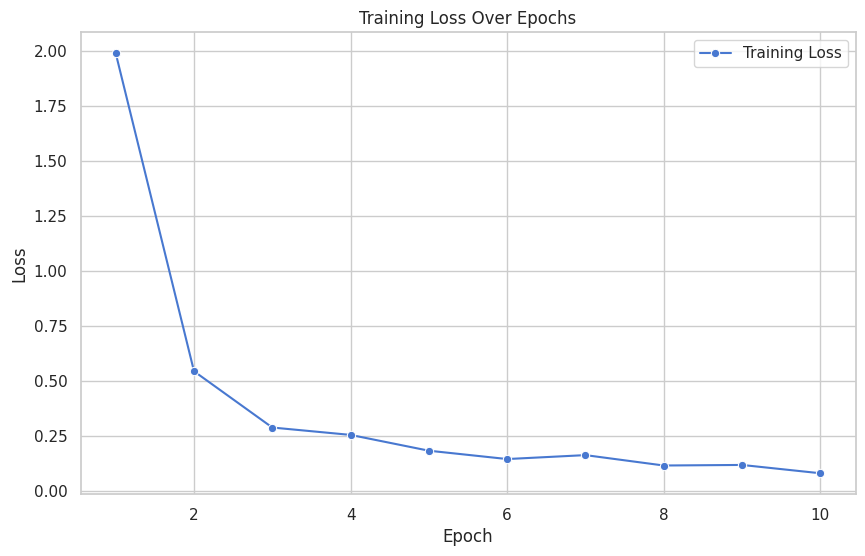

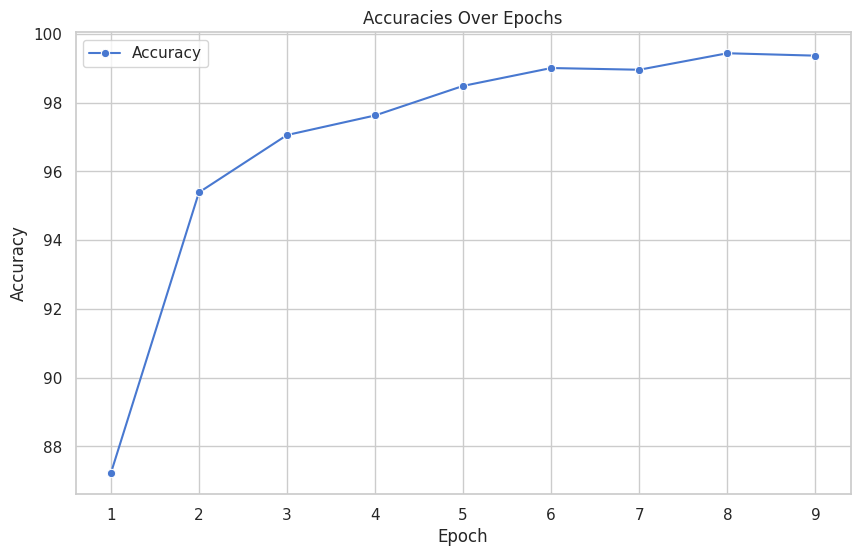

In [17]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(loss_list) + 1), y=loss_list, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(1, len(accuracy_list) + 1), y=accuracy_list, marker='o', label='Accuracy')
plt.title('Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [29]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_loader):
        data = data.cuda()
        targets = targets.cuda()
        test_outputs = totalLossCL(data)

        # Assuming test_outputs is a tuple (loss, logits)
        logits = test_outputs[1]

        _, predicted_test = torch.max(logits, 1)
        test_accuracy += (predicted_test == targets).sum().item() / len(targets)

print(f'\n test accuracy : {(test_accuracy/len(test_loader))*100:.5f}')


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


 test accuracy : 95.56055
